In [1]:
import sys, os
print(os.path.dirname(sys.executable))

import pickle
import time
import os
from sys import platform

import numpy as np
import matplotlib.pyplot as plt
from geant3_parser import Geant3DataFile
from geant3_parser import build_true_answers_train_set

from event_display import print_tabled_event

from keras.models import Sequential
from keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, UpSampling2D, Cropping2D, Input, Conv2DTranspose



/home/n3/miniconda3/envs/dl/bin


2022-06-03 23:48:56.183088: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
file_name = os.path.join('data', 'shower_geant3_new.dat')

def norm_func(e):
    return np.float64(np.log(e) / 11)


# file_name = 'sample_data.txt'
data_file = Geant3DataFile(file_name, skip_lines=3)

# split into input (X) and output (y) variables
parse_start = time.time()
print(f"Start preparing events...")

inputs, answers, values = build_true_answers_train_set(data_file, 200000, norm_func=norm_func, rnd_shift=((-2,2), (-2,2)) )
parse_end = time.time()
print(f"Inputs shape original = {np.shape(inputs)}")
print(f"Total events prepare time = {parse_end - parse_start}")
print(f"max hit value = {np.max(inputs)}")

Time open 2.114060163497925
Time split 1.0749866962432861
Start preparing events...
Inputs shape original = (200000, 11, 11)
Total events prepare time = 31.75800132751465
max hit value = 0.7609799248146092


In [3]:
inputs = np.reshape(inputs, (len(inputs), 11, 11, 1))  # -1 => autodetermine
answers = np.reshape(answers, (len(answers), 121))  # -1 => autodetermine
# # Pad with 1 row and column of zeroes, so it divides by 2
#inputs = np.pad(inputs, ((0,0), (0,1), (0,1), (0,0)), mode='constant', constant_values=0)
#answers = np.pad(answers, ((0,0), (0,1), (0,1), (0,0)), mode='constant', constant_values=0)
print(f"Inputs shape new = {np.shape(inputs)}")
print(f"Answers shape new = {np.shape(answers)}")

print_tabled_event(inputs[0])
print(answers[0])

Inputs shape new = (200000, 11, 11, 1)
Answers shape new = (200000, 121)

                                COLUMNS                                
ROW   0     1     2     3     4     5     6     7     8     9     10   
-----------------------------------------------------------------------
0   | 0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1   | 0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2   | 0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3   | 0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4   | 0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.69  0.0   0.0   0.0  
5   | 0.0   0.0   0.0   0.69  0.0   0.0   1.4   0.0   0.0   0.0   0.0  
6   | 0.0   0.0   0.0   1.8   3.3   2.9   3.5   2.2   0.0   0.0   0.0  
7   | 0.0   0.0   2.1   1.8   3.6   7.4   5.0   2.2   1.6   0.0   0.0  
8   | 0.0   0.0   0.0   1.6   3.6   5.0   4.0   1.4   0.0   0.0   0.0  
9   | 0.0   0.0   0.69  1.8   2.2   3.0   2.5   1.4   0.0   0.

In [4]:
model = Sequential()
model.add(Input(shape=(11, 11, 1)))
model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', kernel_initializer='he_normal'))
model.add(Conv2D(16, kernel_size=(2, 2), activation='relu', kernel_initializer='he_normal'))
model.add(Conv2D(6, kernel_size=(2, 2), activation='relu', kernel_initializer='he_normal'))
model.add(Flatten())
model.add(Dense(121, activation='relu'))
#model.add(Dense(121, activation='relu'))
#model.add(Conv2D(1, kernel_size=(2, 2), activation='sigmoid', padding='same'))
model.summary()

2022-06-03 23:49:39.987309: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-06-03 23:49:40.025216: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-06-03 23:49:40.025468: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: Quadro P1000 computeCapability: 6.1
coreClock: 1.5185GHz coreCount: 4 deviceMemorySize: 4.00GiB deviceMemoryBandwidth: 89.53GiB/s
2022-06-03 23:49:40.025601: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-06-03 23:49:40.032979: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-06-03 23:49:40.033119: I tensorflow/stream_executor/platform/d

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 10, 10, 32)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 16)          2064      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 6)           390       
_________________________________________________________________
flatten (Flatten)            (None, 384)               0         
_________________________________________________________________
dense (Dense)                (None, 121)               46585     
Total params: 49,199
Trainable params: 49,199
Non-trainable params: 0
_________________________________________________________________


In [5]:
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', 'mse', 'mae'])
# output layer
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['acc', 'mse', 'mae'])
#model.compile(optimizer= 'adam', loss = 'binary_crossentropy')
history = model.fit(inputs, answers, epochs=25, batch_size=32, validation_split=0.2)


# compile the keras model

# model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc', 'mse', 'mae'])

# fit the keras model on the dataset
#history = model.fit(inputs, inputs, validation_split=0.05, epochs=20, batch_size=32, verbose=1)

# Save everything
name = "g3_conv"
os.path.join('trained_models', 'g3_conv.hd5')
# Saving history
with open(os.path.join('trained_models',name + "-history.pickle"), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

# Saving the model
model.save(os.path.join('trained_models', name + ".hd5"))

2022-06-03 23:56:59.591353: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-03 23:56:59.593941: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2904005000 Hz


Epoch 1/25


2022-06-03 23:57:16.017523: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-06-03 23:57:18.180125: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2022-06-03 23:57:21.983429: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-06-03 23:57:22.611360: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


5000/5000 [==============================] - 75s 10ms/step - loss: 0.0024 - acc: 0.5378 - mse: 0.0024 - mae: 0.0046 - val_loss: 0.0017 - val_acc: 0.5985 - val_mse: 0.0017 - val_mae: 0.0027
Epoch 2/25
5000/5000 [==============================] - 58s 12ms/step - loss: 0.0017 - acc: 0.5963 - mse: 0.0017 - mae: 0.0027 - val_loss: 0.0017 - val_acc: 0.5985 - val_mse: 0.0017 - val_mae: 0.0027
Epoch 3/25
5000/5000 [==============================] - 56s 11ms/step - loss: 0.0017 - acc: 0.5985 - mse: 0.0017 - mae: 0.0026 - val_loss: 0.0017 - val_acc: 0.5982 - val_mse: 0.0017 - val_mae: 0.0026
Epoch 4/25
5000/5000 [==============================] - 82s 16ms/step - loss: 0.0017 - acc: 0.5968 - mse: 0.0017 - mae: 0.0026 - val_loss: 0.0017 - val_acc: 0.5989 - val_mse: 0.0017 - val_mae: 0.0026
Epoch 5/25
5000/5000 [==============================] - 62s 12ms/step - loss: 0.0017 - acc: 0.5977 - mse: 0.0017 - mae: 0.0026 - val_loss: 0.0017 - val_acc: 0.5989 - val_mse: 0.0017 - val_mae: 0.0026
Epoch 6/25


2022-06-04 00:28:45.645258: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: trained_models/g3_conv.hd5/assets


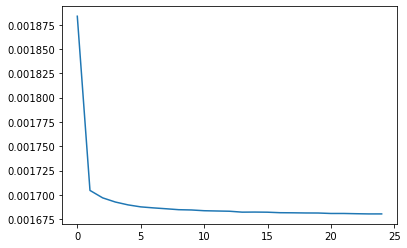

In [6]:
plt.plot(history.history['loss'])
    

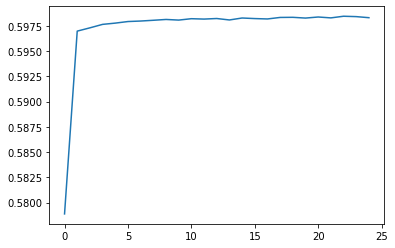

In [7]:
plt.plot(history.history['acc'])

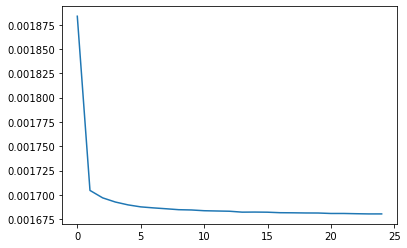

In [8]:
plt.plot(history.history['mse'])

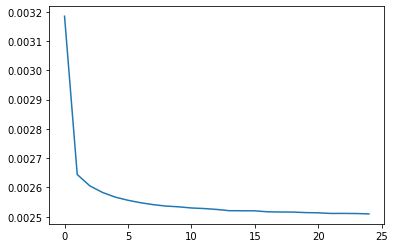

In [9]:
plt.plot(history.history['mae'])